In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [7]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic

# Reproducing case-B Recombination Coefficients

In [8]:
rs_vec = 10**np.arange(1,4,.5)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)
length = len(rs_vec)

In [9]:
%autoreload
# alpha_B requires many excited states to converge (see Hummer Fig. 1)
nmax = 300
Delta_f = lambda a : 0

alpha_tot=np.zeros(length)
for i, rs in enumerate(rs_vec):
    Tm = phys.Tm_std(rs)

    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, nmax, k2_tab, g)
    alpha_tot[i] = np.sum(alpha)
    
    print(rs, alpha_tot[i])

10.0 7.799962198137497e-11
31.622776601683793 2.1951731538439943e-11
100.0 6.282975017381123e-12
316.22776601683796 2.2862697996764468e-12
1000.0 1.0294850166269901e-12
3162.2776601683795 4.634429288502124e-13


In [10]:
# Tm^1/2 * alpha_B from Hummer 1994 MNRAS
Tm_alphaB_Hummer = np.array([
    9.283e-11, 8.823e-11, 8.361e-11,
    7.898e-11, 7.435e-11, 6.973e-11,
    6.512e-11, 6.054e-11, 5.599e-11,
    5.147e-11, 4.700e-11, 4.258e-11,
    3.823e-11, 3.397e-11, 2.983e-11,
    2.584e-11, 2.204e-11, 1.847e-11,
    1.520e-11, 1.226e-11, 9.696e-12,
    7.514e-12, 5.710e-12, 4.257e-12,
    3.117e-12, 2.244e-12, 1.590e-12,
    1.110e-12, 7.642e-13, 5.199e-13,
3.498e-13])

#Convert to eV
Tm_Hummer = 10**np.arange(1,7.2,.2)*phys.kB

alphaB_Hummer = interp1d(Tm_Hummer, Tm_alphaB_Hummer/np.sqrt(Tm_Hummer/phys.kB))

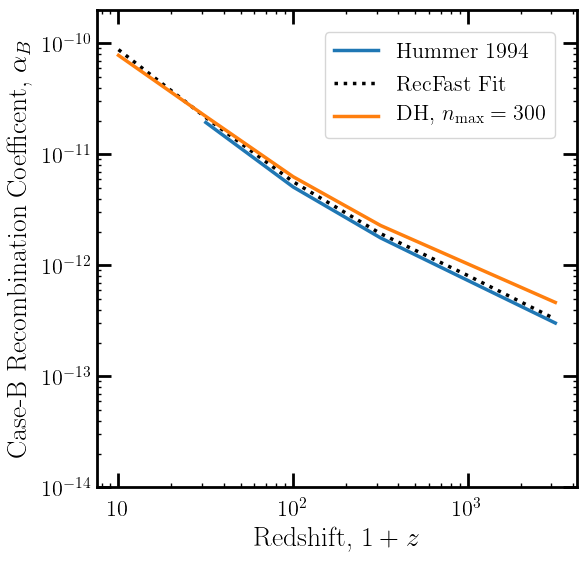

In [11]:
rs_vec = 10**np.arange(1,4,.5)
Tm_vec = phys.Tm_std(rs_vec)
plt.figure()
plt.loglog()
plt.ylim([1e-14,2e-10])

plt.plot(rs_vec[Tm_vec>8e-4], alphaB_Hummer(Tm_vec[Tm_vec>8e-4]), label='Hummer 1994')
plt.plot(rs_vec, phys.alpha_recomb(Tm_vec, 'HI'), label='RecFast Fit', color='k', linestyle=':')
plt.plot(rs_vec, alpha_tot, label=r'DH, $n_{\mathrm{max}}=300$')
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Case-B Recombination Coefficent, $\alpha_B$', fontsize=20)
plt.legend()

$\beta_B$ is obtained by detailed balance. 
First, use $x_i \beta_i \sim \frac1{g_i}e^{-E_i/T_m}\alpha_i$.
Next, assume $x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m}$. 
Finally, write the ionization term in the $x_e$ evolution equation as 
$$
\sum_i \beta_i x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m} \sim x_{2s}e^{-E_2/T_m} \alpha_B \sim \beta_B x_{2s}
$$
So a cross-cheeck of $\alpha_B$ is a cross-check of $\beta_B$.

# Deviations from TLA Assumptions

The TLA assumes that the excited states obey the detailed balance condition
$$
\begin{alignat}{1}
	\frac{x_i}{x_{2s}} = g_i e^{-(E_i-E_\alpha)/T} \, ,
\end{alignat}
$$
that the $n=2$ state obeys
$$
\begin{alignat}{1}
	x_2 = & \frac{x_{1s}e^{-E_\alpha/T} (3 R_{\text{Ly}\alpha} + \Lambda_{2s}) + x_e^2 n_H \alpha_\text{B}}{
	\frac34 R_{\text{Ly}\alpha} + \frac14 \Lambda_{2s} + \beta_\text{B}}   \, ,
\end{alignat}
$$
and that the substates satisfy 
$$
\begin{alignat}{1}
	x_{2p} = & \frac34 x_2 \\
    x_{2s} = & \frac14 x_2 \, .
\end{alignat}
$$

We also assume that the excited state abundances are so exponentially suppressed that $$x_{1s} = 1-x_e \, .$$
Let us now see if we can reproduce this behavior.

In [207]:
%autoreload
rs_vec = 10**np.arange(1,4.55,.05)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)

length = len(rs_vec)

xe_vec = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

#2p-1s rate without optical depth
f_Lya = np.exp(-phys.lya_eng/Tr_vec)/(1-np.exp(-phys.lya_eng/Tr_vec))
R_Lya_vec = 2**9/3**8 * phys.alpha**3 * phys.rydberg/phys.hbar * (1+f_Lya)

#Sobolev optical depth
tau_vec = atomic.tau_np_1s(2,rs_vec)
R_Lya_vec *= (1-np.exp(-tau_vec))/tau_vec

# lam_a = 2*np.pi * phys.hbar * phys.c/phys.lya_eng
# R_Lya_vec = 8*np.pi*phys.hubble(rs_vec)/(3*x1s_vec*nH_vec*lam_a**3)

#2s-1s rate
Lam2s = phys.width_2s1s_H

#Total deexcitation rate
sum_rates = (3*R_Lya_vec + Lam2s)/4

#Denominator of Peebles C factor
denom = sum_rates + phys.beta_ion(Tr_vec,'HI')

#Two numerator terms for x2 steady state solution
term1 = xe_vec**2 * nH_vec * phys.alpha_recomb(Tm_vec, 'HI')
term2 = 4 * x1s_vec * np.exp(-phys.lya_eng/Tr_vec) * sum_rates

x2_vec = (term1+term2)/denom

In [208]:
def E(n):
    return phys.rydberg/n**2

def g_nl(l):
    return 2*l+1

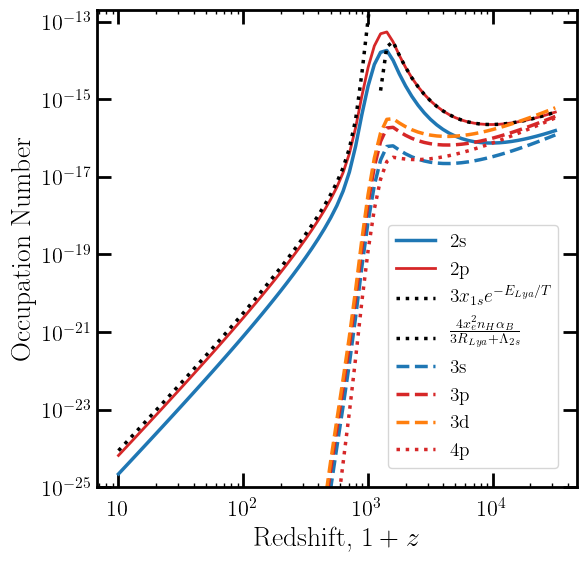

In [259]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

plt.plot(rs_vec, x2s_vec, label='2s', color='C0')
plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=2.0)
plt.plot(rs_vec[rs_vec>1.2e3], (3*x1s_vec*np.exp(-phys.lya_eng/Tr_vec))[rs_vec>1.2e3], 
         label=r'$3 x_{1s} e^{-E_{Lya} / T}$', color='k', linestyle=':')
plt.plot(rs_vec[rs_vec<1.2e3], (term1/sum_rates)[rs_vec<1.2e3], 
         label=r'$\frac{4 x_e^2 n_H \alpha_B}{3 R_{Lya} + \Lambda_{2s}}$', color='k', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C0', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C3', linestyle='--')
plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C1', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(fontsize=14)

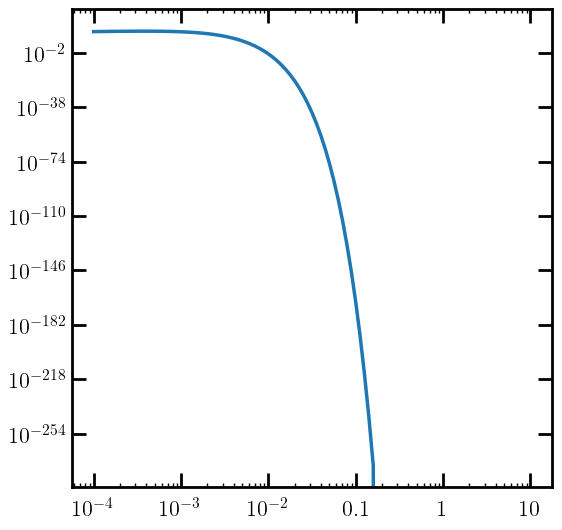

In [370]:
eng = 10**np.arange(-4,1.05,.05)
plt.figure()
plt.loglog()
plt.plot(eng, phys.CMB_spec(eng, phys.TCMB(1))/phys.nB)

Now we would like to see if $Mx = b$ produces a solution near the above lines.

### Checking Detailed Balance

In [218]:
# Exponentially small numbers have significant round-off error
print(1-phys.xHII_std(3e4), phys.xHI_std(3e4))

6.661338147750939e-16 6.260822950335344e-16


In [219]:
%autoreload
rs = 3e3
xe = phys.xHII_std(rs)
Tr = phys.TCMB(rs)
mu_e = phys.me/(1+phys.me/phys.mp)

lam_T = phys.c * 2*np.pi*phys.hbar / np.sqrt(2 * np.pi * mu_e * Tr)
rhs = lam_T**-3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/Tr)
phys.xHI_std(rs) * rhs/xe**2

0.9999999999999999

In [220]:
%autoreload
# R['dn'][2][1][1]**2 = 2**15/3**9
# BB['dn'][2][1][1] = 2**9/3**8 * phys.alpha**3 * phys.rydberg/phys.hbar * (1+fEnnp)
ind=-1
Tr=Tr_vec[ind]
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
Ennp = phys.lya_eng
fEnnp = np.exp(-Ennp/Tr)/(1-np.exp(-Ennp/Tr))
print(BB['dn'][2][1][1]/(1+fEnnp), atomic.p_np_1s(2, rs_vec[ind], xHI=x1s_vec[ind]))

626831481.8234394 0.9999880727592952


In [501]:
# Detailed Balance amongst the bound-bound transitions
print('n1 l n2')
n1,l = 1,0
for n2 in np.arange(2,nmax+1):
    Ennp = E(n1)-E(n2)
    print(n1,'',l,n2,':',
          BB['up'][n1][n2][l]/(BB['dn'][n2][n1][l+1])/(
         np.exp(-Ennp/Tr)*g_nl(l+1)/g_nl(l)))
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
1  0 2 : 1.0000000000000002
1  0 3 : 1.0000000000000002
1  0 4 : 0.9999999999999999
1  0 5 : 0.9999999999999999
1  0 6 : 0.9999999999999999
1  0 7 : 0.9999999999999998
1  0 8 : 1.0
1  0 9 : 0.9999999999999998
3  1 2 : 1.0
4  1 2 : 0.9999999999999999
4  1 3 : 0.9999999999999999
4  2 3 : 1.0
5  1 2 : 1.0
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999999
5  3 4 : 1.0000000000000002
6  1 2 : 0.9999999999999997
6  1 3 : 0.9999999999999998
6  2 3 : 0.9999999999999999
6  1 4 : 1.0000000000000002
6  2 4 : 1.0
6  3 4 : 1.0000000000000002
6  1 5 : 1.0000000000000002
6  2 5 : 1.0
6  3 5 : 1.0000000000000002
6  4 5 : 1.0000000000000002
7  1 2 : 1.0
7  1 3 : 0.9999999999999999
7  2 3 : 0.9999999999999999
7  1 4 : 1.0000000000000004
7  2 4 : 1.0
7  3 4 : 1.0000000000000002
7  1 5 : 0.9999999999999999
7  2 5 : 1.0
7  3 5 : 1.0
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0
7  3 6 : 1.0000000000000002
7  4 6 : 1.0000000000000

In [ ]:
print('n1 l n2')
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

In [364]:
#Saha equilibrium at large redshift
hplanck = 2*np.pi * phys.hbar
mu_e = phys.me/(1+phys.me/phys.mp)
lam_T = hplanck*phys.c/(2*np.pi * mu_e*Tr_vec)**(1/2)

(phys.xHI_std(rs_vec)/nH_vec/xe_vec**2)*np.exp(-E(1)/Tr_vec)/g_nl(0)/lam_T**3

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.30827243e-290, 5.14176219e-256,
       2.04926450e-225, 3.73220887e-198, 7.16123808e-174, 3.04720201e-152,
       5.58062404e-133, 7.93955819e-116, 1.48464927e-100, 5.82339401e-087,
       7.27561442e-075, 4.19843224e-064, 1.55224842e-054, 4.92969783e-046,
       1.73756164e-038, 8.52465625e-032, 7.07764296e-026, 1.16561874e-020,
       4.21766284e-016, 3.39672183e-012, 5.18208218e-009, 1.07903634e-006,
       5.43008162e-005, 1.57474620e-003, 3.42015062e-002, 4.15834107e-001,
       1.00661112e+000, 1.00581965e+000, 1.00377108e+000, 1.00000000e+000,
       9.99999999e-001, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1

In [482]:
%autoreload

#Detailed Balance between recombination and ionization
rs = 3e3
Tr = phys.TCMB(rs)
Tm = Tr#phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3

nmax=9
R = atomic.populate_radial(nmax)
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

hplanck=2*np.pi*phys.hbar
mu_e = phys.me/(1 + phys.me/phys.mp)
lam_T = hplanck*phys.c/(2*np.pi * mu_e * Tr)**(1/2)

for n in np.arange(1,nmax+1):
    for l in np.arange(0,n):
        print(n,l,':', beta[n][l]/(
            alpha[n][l]*np.exp(-E(n)/Tr)/g_nl(l)/lam_T**3))#xe**2*nH * 

1 0 : 1.0000000000000016
2 0 : 0.9999999999999997
2 1 : 1.0
3 0 : 1.0
3 1 : 1.0
3 2 : 0.9999999999999999
4 0 : 1.0000000000000002
4 1 : 1.0
4 2 : 1.0000000000000002
4 3 : 1.0000000000000002
5 0 : 1.0000000000000004
5 1 : 1.0000000000000004
5 2 : 1.0
5 3 : 1.0000000000000002
5 4 : 1.0000000000000002
6 0 : 1.0
6 1 : 1.0000000000000004
6 2 : 1.0000000000000002
6 3 : 1.0000000000000002
6 4 : 1.0000000000000002
6 5 : 0.9999999999999998
7 0 : 0.9999999999999998
7 1 : 1.0000000000000002
7 2 : 1.0000000000000002
7 3 : 1.0
7 4 : 0.9999999999999998
7 5 : 1.0000000000000002
7 6 : 1.0000000000000002
8 0 : 0.9999999999999999
8 1 : 1.0
8 2 : 1.0
8 3 : 1.0
8 4 : 0.9999999999999998
8 5 : 1.0
8 6 : 1.0
8 7 : 0.9999999999999999
9 0 : 0.9999999999999998
9 1 : 1.0
9 2 : 0.9999999999999998
9 3 : 0.9999999999999999
9 4 : 0.9999999999999997
9 5 : 1.0000000000000002
9 6 : 1.0000000000000002
9 7 : 1.0000000000000002
9 8 : 0.9999999999999999


In [365]:
rs=3e3
Tr=phys.TCMB(rs)
x_tmp = np.zeros(num_states)
x_tmp[0] = phys.xHI_std(rs)

for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    x_tmp[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x_tmp[0]

In [366]:
x_tmp

array([6.98557344e-10, 3.58558368e-16, 1.07567510e-15, 2.45364262e-17,
       7.36092785e-17, 1.22682131e-16, 9.59730533e-18, 2.87919160e-17,
       4.79865267e-17, 6.71811373e-17, 6.21527066e-18, 1.86458120e-17,
       3.10763533e-17, 4.35068946e-17, 5.59374359e-17, 4.90865120e-18,
       1.47259536e-17, 2.45432560e-17, 3.43605584e-17, 4.41778608e-17,
       5.39951632e-17, 4.25754443e-18, 1.27726333e-17, 2.12877221e-17,
       2.98028110e-17, 3.83178998e-17, 4.68329887e-17, 5.53480775e-17,
       3.88192083e-18, 1.16457625e-17, 1.94096042e-17, 2.71734458e-17,
       3.49372875e-17, 4.27011292e-17, 5.04649708e-17, 5.82288125e-17,
       3.64372562e-18, 1.09311769e-17, 1.82186281e-17, 2.55060794e-17,
       3.27935306e-17, 4.00809819e-17, 4.73684331e-17, 5.46558844e-17,
       6.19433356e-17])

In [753]:
nl=1
n,l=2,0
R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
beta[2][0]*x_lte[nl]-xe**2 * nH * alpha[2][0]

1.3234889800848443e-23

In [865]:
nl=3
n = states_n[nl]
l = states_l[nl]
print('state', n, l)


R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
print(BB['dn'][n, :, l]/R_tot)
print(BB['up'][n, :, l]/R_tot)
-x_lte[nl]*(np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])+0*beta[n][l])

state 3 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.06489002 0.         0.22795261 0.0815303
 0.04011131 0.02308861 0.01463144 0.00990327]


-2.411653725891526e-08

In [747]:
# Undetailed balance: Seeing that each line of the MLA is satisfied 
# by x_i in LTE
diff_vec = np.zeros(num_states)
for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
    if nl != num_states-1:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['dn'][1:,n,l+1]/R_tot*x_lte[np.array([nl_vec(n,l+1) for n in np.arange(1,nmax+1)])]
            +BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
    else:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
        
    if nl==1:
#         diff_vec[nl] -= BB['dn'][2,1,0]/R_tot*x_lte[1]
        diff_vec[nl] += BB['dn'][2,1,0]*np.exp((E(2)-E(1))/Tr)/R_tot*x_lte[0]
        
    print(n,l,diff_vec[nl]/x_lte[nl])
    
print(np.linalg.norm(diff_vec)/np.linalg.norm(x_lte))

2 0 -1.741652589019149e-16
2 1 4.761515247438263e-16
3 0 -3.0705270934778197e-16
3 1 1.0235090311592731e-16
3 2 -3.2752288997096737e-16
4 0 0.0
4 1 7.458897387784654e-17
4 2 8.950676865341587e-17
4 3 -1.1987513658939624e-16
5 0 -5.829570133407884e-17
5 1 3.88638008893859e-16
5 2 1.3990968320178922e-16
5 3 -3.331182933375934e-17
5 4 -1.5545520355754357e-16
6 0 5.961565686473888e-17
6 1 2.3846262745895557e-16
6 2 0.0
6 3 1.7033044818496824e-17
6 4 2.914543224498346e-16
6 5 1.4090973440756463e-16
7 0 -4.834075915951361e-16
7 1 -2.0141982983130666e-16
7 2 -2.4170379579756803e-16
7 3 -1.726455684268343e-16
7 4 2.685597731084089e-17
7 5 6.591921703570037e-17
7 6 9.296299838368e-17
8 0 -4.267042089153067e-16
8 1 -3.251079686973765e-16
8 2 -4.876619530460648e-17
8 3 -5.224949496922122e-16
8 4 8.127699217434414e-17
8 5 2.2166452411184763e-17
8 6 -5.626868688993055e-17
8 7 -1.8896900680535011e-16
9 0 2.4530017194797316e-16
9 1 2.4530017194797316e-16
9 2 3.4342024072716244e-16
9 3 7.0085763413706

In [866]:
BB['dn'][1:,n,l+1]/R_tot

array([0.        , 0.016771  , 0.        , 0.08306107, 0.03095798,
       0.01557558, 0.00908737, 0.00580942, 0.00395579])

In [867]:
BB['up'][1:,n,l-1]/R_tot

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [868]:
P_matrix[nl]

array([0.        , 0.        , 0.        , 0.        , 0.23072008,
       0.        , 0.        , 0.07678617, 0.        , 0.        ,
       0.        , 0.03577597, 0.        , 0.        , 0.        ,
       0.        , 0.01973418, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0120853 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00795391,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00551972, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [764]:
np.transpose(P_matrix)[nl]

array([0.        , 0.        , 0.        , 0.06489002, 0.        ,
       0.44954373, 0.03340482, 0.        , 0.20173517, 0.        ,
       0.0229207 , 0.        , 0.13483545, 0.        , 0.        ,
       0.01786789, 0.        , 0.10488754, 0.        , 0.        ,
       0.        , 0.0150885 , 0.        , 0.08903891, 0.        ,
       0.        , 0.        , 0.        , 0.01372286, 0.        ,
       0.08168011, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01441613, 0.        , 0.08701283, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [762]:
P_matrix[:,nl]

array([0.        , 0.        , 0.        , 0.06489002, 0.        ,
       0.44954373, 0.03340482, 0.        , 0.20173517, 0.        ,
       0.0229207 , 0.        , 0.13483545, 0.        , 0.        ,
       0.01786789, 0.        , 0.10488754, 0.        , 0.        ,
       0.        , 0.0150885 , 0.        , 0.08903891, 0.        ,
       0.        , 0.        , 0.        , 0.01372286, 0.        ,
       0.08168011, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01441613, 0.        , 0.08701283, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [804]:
nl = 2
n,l=states_n[nl],states_l[nl]

R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
-x_lte[nl]+np.dot(P_matrix[:,nl],x_lte) + xe**2 * nH * alpha[n][l]/R_tot

3.6036573184818667e-16

In [816]:
ssum = 0#x1s*BB['up'][1,n,0]/R_tot#-x_lte[nl]*np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
for nlp in np.arange(1, num_states):
#     nlp = nlpp-1
    n_p = states_n[nlp]
    lp = states_l[nlp]
    
    ssum += P_matrix[nl][nlp]*x_lte[nlp]
    
    print(n_p, lp, P_exc[nl-1][nlp-1])
#     print(n_p, lp, P_matrix[nl][nlp])

2 0 0.0
2 1 0.0
3 0 0.004566655588165175
3 1 0.0
3 2 0.233812766114057
4 0 0.0013182501540904715
4 1 0.0
4 2 0.05273000616361888
4 3 0.0
5 0 0.0005755799377513708
5 1 0.0
5 2 0.021049780580621562
5 3 0.0
5 4 0.0
6 0 0.00030655978574395344
6 1 0.0
6 2 0.010729592501038372
6 3 0.0
6 4 0.0
6 5 0.0
7 0 0.00018382757953965082
7 1 0.0
7 2 0.006274648048286748
7 3 0.0
7 4 0.0
7 5 0.0
7 6 0.0
8 0 0.00011934753948245633
8 1 0.0
8 2 0.004010077326610534
8 3 0.0
8 4 0.0
8 5 0.0
8 6 0.0
8 7 0.0
9 0 8.205335971400614e-05
9 1 0.0
9 2 0.0027280078034786453
9 3 0.0
9 4 0.0
9 5 0.0
9 6 0.0
9 7 0.0
9 8 0.0


In [827]:
ssum

3.3326670348957174e-18

In [821]:
x_lte[nl]

4.659590866852228e-16

In [829]:
beta[n][l]*x_lte[nl]/tot_rate

6.708926284534344e-18

In [830]:
b[nl]

6.708926284534345e-18

In [819]:
x1s*BB['up'][1,n,0]/R_tot

2.457163012326999e-16

In [807]:
ssum-x_lte[nl]*np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])

-2.4570766020203623e-07

In [530]:
def nl_vec(n,l):
    return int((n-1)*n/2)+l
x0 = x_lte[nl]
print('from', n,l)
print('to')
for nlp in np.arange(0, num_states):
    n_p = states_n[nlp]
    lp = states_l[nlp]
    
    if lp == l+1:
        x_up = x_lte[nl_vec(n_p,l+1)]
        print(n_p,lp,BB['dn'][n_p, n, l+1]*x_up-BB['up'][n, n_p, l]*x0)
    elif lp == l-1:
        x_dn = x_lte[nl_vec(n_p,l-1)]
#         print(x_dn, x0)
        print(n_p,lp,BB['up'][n_p, n, l-1]*x_dn-BB['dn'][n, n_p, l]*x0)

from 2 1
to
1 0 1.0587911840678754e-22
2 0 0.0
3 0 4.1359030627651384e-25
3 2 7.940933880509066e-23
4 0 2.0679515313825692e-25
4 2 -6.617444900424222e-24
5 0 1.0339757656912846e-25
5 2 0.0
6 0 7.754818242684634e-26
6 2 1.6543612251060553e-24
7 0 0.0
7 2 0.0
8 0 5.169878828456423e-26
8 2 8.271806125530277e-25
9 0 -1.2924697071141057e-26
9 2 0.0


In [828]:
%autoreload
#Get transition energies
nmax=9
skip=1
H_engs = atomic.get_transition_energies(nmax)
num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s
for i in np.arange(-1,0):#length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    P_matrix = np.zeros((num_states, num_states))
    PtoCont = np.zeros(num_states)
    b = np.zeros(num_states)
    for nl in np.arange(1, num_states):
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s

        if l != 0:
            dn_inds = np.where(states_l == l-1)[0]
            dn_rates = BB['dn'][n, states_n[dn_inds], l]
        else:
            # If angular momentum is 0, can only transition up
            dn_rates = 0

        if nl == 2:
            print(dn_rates)
        up_inds = np.where(states_l == l+1)[0]
        up_rates = BB['up'][n, states_n[up_inds], l]
        tot_rate = np.sum(up_rates) + np.sum(dn_rates) + beta[n][l]
        
#         if n>2:
#             tot_rate -= beta[n][l]

        # Special 2s->1s transition
        if nl == 1:
            tot_rate += BB['dn'][2][1][0]
            P_matrix[1][0] = BB['dn'][2][1][0] / tot_rate

        # Normalize by total rate for each state to get probabilities instead of rates
        if l != 0:
            P_matrix[nl][dn_inds] = dn_rates / tot_rate
        P_matrix[nl][up_inds] = up_rates / tot_rate
        PtoCont[nl] = beta[n][l] / tot_rate

        b[nl] = xe**2 * nH * alpha[n][l] / tot_rate
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0] / tot_rate
        
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr) / tot_rate
            
#         if n>2:
#             b[nl]=0

    
    # Vector of probabilities for single transition
    Pto1s = P_matrix[:,0]

    #Probability matrix for only the excited states
    P_exc = P_matrix[1:,1:]
    
    err = np.matmul(ident - np.transpose(P_exc),x_lte[1:])-b[1:]
#     print(np.matmul(ident - np.transpose(P_exc),x_lte[1:]))
#     print(b[1:])
    print(err)
    print(np.linalg.norm(err)/np.linalg.norm(x_lte))

#     M_inv = np.linalg.inv(ident - np.transpose(P_exc))
#     x_vec[i] = np.matmul(M_inv,b[1:])
    x_vec[i] = np.linalg.solve(ident - np.transpose(P_exc),b[1:])

[8.39247275e+08 0.00000000e+00 7.26778405e+06 2.09798117e+06
 9.16029381e+05 4.87886656e+05 2.92559648e+05 1.89940346e+05
 1.30587054e+05]
[-9.07482997e-17 -5.00139946e-16 -4.24927619e-17 -2.47626802e-16
 -2.73656983e-16 -2.16272307e-17 -1.35937749e-16 -1.44670686e-16
 -2.43294643e-16 -9.55591256e-18 -7.59887478e-17 -5.66880482e-17
 -1.56330392e-16 -2.13546608e-16 -1.32958467e-18 -3.78532395e-17
  3.76484880e-18 -6.74783088e-17 -1.61133160e-16 -2.04845511e-16
  5.11753044e-18 -9.55094976e-18  5.08418826e-17  1.09218314e-17
 -7.69517830e-17 -1.94443868e-16 -2.60220990e-16  1.14084139e-17
  1.73205950e-17  9.94881175e-17  9.57469805e-17  3.69514867e-17
 -1.07980956e-16 -3.67174327e-16 -7.66946201e-16  2.28927406e-17
  6.93547145e-17  2.10687013e-16  3.12678050e-16  4.29628612e-16
  5.60467900e-16  7.00402413e-16  8.42338307e-16  9.88202249e-16]
0.39017433029340975


In [855]:
x_lte

array([6.13641017e-16, 1.55319696e-16, 4.65959087e-16, 1.20428362e-16,
       3.61285087e-16, 6.02141812e-16, 1.10167772e-16, 3.30503317e-16,
       5.50838862e-16, 7.71174407e-16, 1.05719216e-16, 3.17157647e-16,
       5.28596078e-16, 7.40034510e-16, 9.51472941e-16, 1.03378477e-16,
       3.10135432e-16, 5.16892386e-16, 7.23649340e-16, 9.30406295e-16,
       1.13716325e-15, 1.01992206e-16, 3.05976617e-16, 5.09961029e-16,
       7.13945441e-16, 9.17929852e-16, 1.12191426e-15, 1.32589868e-15,
       1.01102426e-16, 3.03307278e-16, 5.05512131e-16, 7.07716983e-16,
       9.09921835e-16, 1.11212669e-15, 1.31433154e-15, 1.51653639e-15,
       1.00496885e-16, 3.01490656e-16, 5.02484427e-16, 7.03478198e-16,
       9.04471969e-16, 1.10546574e-15, 1.30645951e-15, 1.50745328e-15,
       1.70844705e-15])

In [857]:
np.dot(P_matrix[1][1:],x_lte[1:])

7.408332897451672e-17

In [856]:
b[1]

8.123636658722422e-17

In [876]:
%autoreload
#Get transition energies
nmax=20
skip=1
H_engs = atomic.get_transition_energies(nmax)
num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s
for i in np.arange(0,length,skip):#(-1,0):#(0,length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    P_matrix = np.zeros((num_states, num_states))
    PtoCont = np.zeros(num_states)
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            P_matrix[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            P_matrix[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            P_matrix[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            P_matrix[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] = xe**2 * nH * alpha[n][l] / tot_rate
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0] / tot_rate
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr) / tot_rate

    #Probability matrix for only the excited states
    M = ident - P_matrix[1:,1:]
    
#     err = np.matmul(M,x_lte[1:])-b[1:]
# #     print(np.matmul(ident - np.transpose(P_exc),x_lte[1:]))
# #     print(b[1:])
#     print(err)
#     print(np.linalg.norm(err)/np.linalg.norm(x_lte))

#     M_inv = np.linalg.inv(ident - np.transpose(P_exc))
#     x_vec[i] = np.matmul(M_inv,b[1:])
    x_vec[i] = np.linalg.solve(M,b[1:])

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


In [742]:
BB['dn'][1:,2,1+1]#/R_tot
# BB['up'][1:,n,l-1]/R_tot

array([0.00000000e+00, 0.00000000e+00, 2.87952581e+08, 7.09879755e+07,
       2.95307976e+07, 1.53934028e+07, 9.12439175e+06, 5.88264589e+06,
       4.02600716e+06])

In [872]:
x_vec[-1,2]/x_vec[-1,0]*np.exp(-(E(3) - E(2))/Tr_vec[-1])

0.9999999999999999

In [873]:
x_vec[-1,1]/x_vec[-1,0]/3

1.0000000000000002

In [874]:
x2s_vec[-1]

1.5531969556174096e-16

In [949]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [950]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

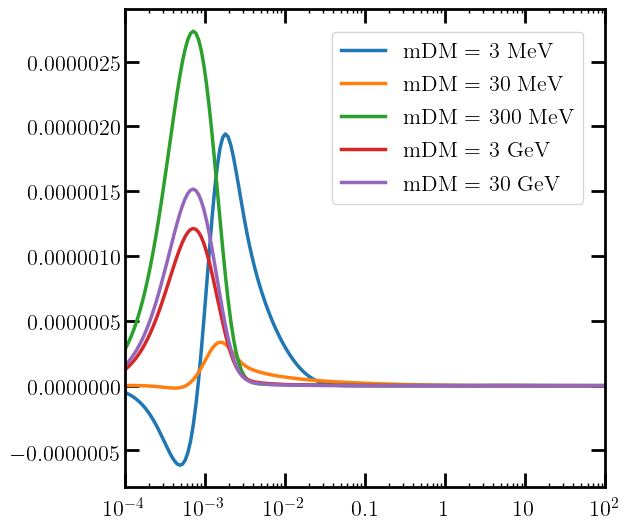

In [951]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()

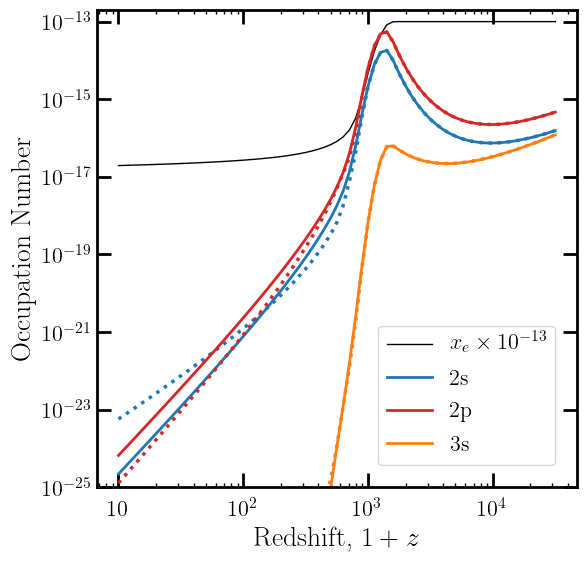

In [875]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)


lw=2.0
plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), 
         label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2')
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4')
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend()

Text(0.5, 1.0, 'Testing the TLA Assumptions')

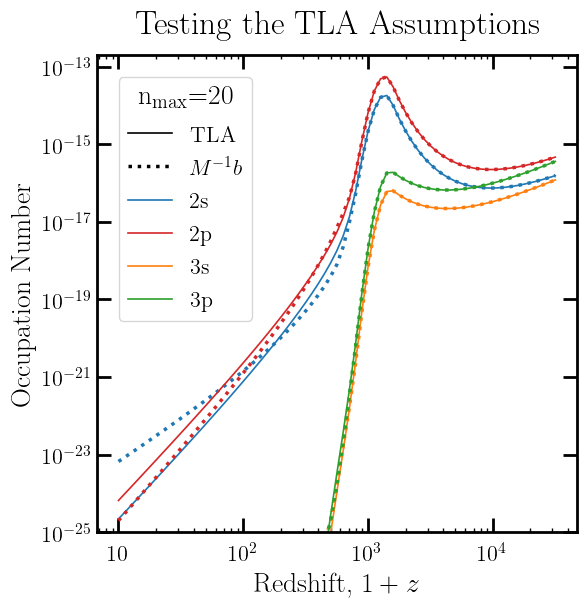

In [888]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

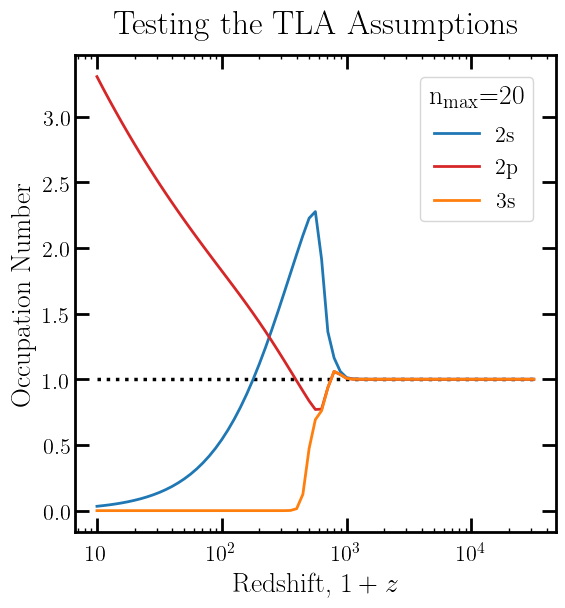

In [900]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')